Tensorflow demo to train a neural network to classify digits

In [87]:
import tensorflow as tf
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
m = x_train.shape[0] # m is the total number of samples

print("m = " + str(m))

print("Shape of training data x_train: " + str(x_train.shape) + " y_train : " + str(y_train.shape))
print("Shape of test data : " + str(x_test.shape))

m = 60000
Shape of training data x_train: (60000, 28, 28) y_train : (60000,)
Shape of test data : (10000, 28, 28)


Print some random digits

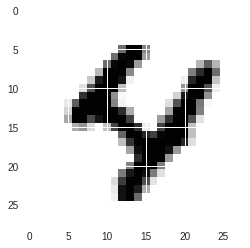

Y Label : 4


In [88]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

digit_index = 729
some_digit = x_train[digit_index]

plt.imshow(some_digit, cmap = matplotlib.cm.binary, interpolation="nearest")
#plt.axis("off")
plt.show()

print("Y Label : " + str(y_train[digit_index]))

Flatten the 2D images to 1D array

In [89]:
# Flatten the images from 2D to 1D
X_train_flatten = x_train.reshape(x_train.shape[0], -1).T
X_test_flatten = x_test.reshape(x_test.shape[0], -1).T
print("X_train_flatten shape = " + str(X_train_flatten.shape))
print("X_test_flatten shape = " + str(X_test_flatten.shape))

X_train_flatten shape = (784, 60000)
X_test_flatten shape = (784, 10000)


Convert class label y to one hot vectors

In [0]:
# Convert each label to a vector of total_classes where only one index that corresponds to the label is one.
# Each label vector is a column vector
def one_hot_matrix(labels):
    
    # There are total 10 digits, thus, C that corresponds to total number of classes is 10
    C = tf.constant(10, name="C")
    one_hot_matrix = tf.one_hot(indices=labels, depth=C, axis=0)
    
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix) 
    sess.close()

    return one_hot

In [91]:
# Convert y-labels to 1 hot representation

y_train_onehot = one_hot_matrix(y_train)
y_test_onehot = one_hot_matrix(y_test)

print("Shape of y_train_onehot : " + str(y_train_onehot.shape))
print("Shape of y_test_onehot : " + str(y_test_onehot.shape))

Shape of y_train_onehot : (10, 60000)
Shape of y_test_onehot : (10, 10000)


In [0]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 = 784)
    n_y -- scalar, number of classes (from 0 to 9, so -> 10)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(tf.float32, shape = (n_x, None))
    Y = tf.placeholder(tf.float32, shape = (n_y, None))
    ### END CODE HERE ###
    
    return X, Y

In [0]:
# Initializes the parameters for the Neural network
# The neural network has 2 hidden layers with 25 nodes in the first layer and 12 nodes in the second layer
# The output layer has 10 nodes corresponding to the 10 output classes
def initialize_parameters():
    
    tf.set_random_seed(7)
    
    W1 = tf.get_variable("W1", shape=[25, 784], initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", [25, 1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12, 1], initializer=tf.zeros_initializer())
    W3 = tf.get_variable("W3", [10, 12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [10,1], initializer = tf.zeros_initializer())
    
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "W3": W3,
        "b3": b3
    }
    
    return parameters

Predict against a random sample

In [0]:
# Implements the forward propagation in the neural network.
# For the 2 hidden layers, RELU is the activation function.
# For the output layer, there's no activation function. 
# Actually, there's sigmoid function, but taken care of in the cost calculation
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, Z1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, Z2), b3)
    
    return Z3

In [0]:
# For the output layer, we use softmax activation function and calculate the overall cost.
# Z3 is the output from the last hidden layer
# Y is the "true" labels vector placeholder
def calculate_cost(Z3, Y):
    
    # Tensorflow expects the shape to be (num_examples, num_classes)
    # Hence, we need to transpose these two
    labels = tf.transpose(Y) # These correspond to y
    logits = tf.transpose(Z3) # These correspond to Z
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

In [96]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(784, 10)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = calculate_cost(Z3, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:
# Now we build the main neural network using the previously built functions

def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001,
         num_epochs = 200, minibatch_size=32, print_cost=True):
    
    ops.reset_default_graph()
    
    tf.set_random_seed(7)
    seed = 3
    (n_x, m) = X_train.shape # Get the number of features and training samples
    n_y = Y_train.shape[0]
    
    costs = [] # To keep track of the costs
    
    # Create placeholders for X and Y
    X, Y = create_placeholders(n_x, n_y)
    
    # Initialize the W and b parameters for all the layers
    parameters = initialize_parameters()
    
    # Forward propagation
    Z3 = forward_propagation(X, parameters)
    
    # Calcualte the cost in forward propagation
    cost = calculate_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    # Start the tensorflow session
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        for epoch in range(num_epochs):
            
            epoch_cost = 0
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 0.914693
Cost after epoch 100: 0.226118


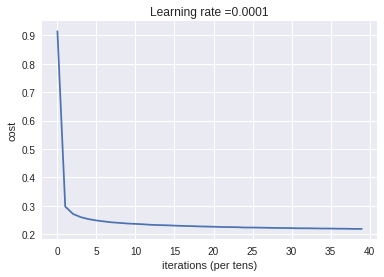

Parameters have been trained!
Train Accuracy: 0.94088334
Test Accuracy: 0.9266


In [106]:
parameters = model(X_train_flatten, y_train_onehot, X_test_flatten, y_test_onehot)